# Train a neural network on ACL-intact knees which have the femur, tibia, and ACL segmented as separate labels.
Requires MONAI v0.5.3. Later version of MONAI (v0.8.0) introduces breaking changes. 

Use run_segmentation.ipynb to load the trained model and run the automatic segmentation on a file.

Last Updated: December 2021


In [2]:
import os
import time
import sys
import tempfile
import glob
import matplotlib.pyplot as plt

import nibabel as nib
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import create_test_image_3d, list_data_collate, decollate_batch
from monai.inferers import sliding_window_inference
from monai.metrics import (
    DiceMetric,
    HausdorffDistanceMetric,
    ConfusionMatrixMetric
)
from monai.transforms import (
    Activations,
    AddChannelD,
    AsChannelFirstd,
    AsDiscrete,
    CenterSpatialCropd,
    Compose,
    CropForegroundd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandCropByPosNegLabeld,
    RandSpatialCropd,
    Spacingd,
    ToTensord,
    ToTensor,
    KeepLargestConnectedComponent,
    LabelToContour
)
from monai.visualize import plot_2d_or_3d_image

from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet, VNet, SegResNet
from monai.utils import set_determinism, first

print('Imports Complete')

Imports Complete


In [2]:
# Run this command if the kernel is dying after imports and jupyter error log refers to OpenMP error
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Load the Data to train the network from
Load the MRI data (images and masks). Split data into training, test, and validation groups. 

In [159]:
# Load images and masks from the ACL google drive folder (or wherever if you are reusing this code :P )
image_path =  'G:\\My Drive\\Pickles\\niftiMRI'
mask_path = 'G:\\My Drive\\Pickles\\niftiMasks' 

# Sort the files and add the nifti suffix to complete the pathnames
train_images = sorted(
    glob.glob(os.path.join(image_path, ("*.nii.gz"))) 
    ) 
train_labels = sorted(
    glob.glob(os.path.join(mask_path, "*.nii.gz")))

# print(train_images)
# print(train_labels)


data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]

# Divide up the dataset into train, test, validation. Approx 80/15/5 split.
train_files, val_files = data_dicts[30:], data_dicts[:30]
test_files, val_files = val_files[:10], val_files[10:]

print('-----------------------')

print("TOTAL files: ", len(data_dicts))
print("TRAIN: ", len(train_files))
print("TEST: ", len(test_files))
print("VALIDATION: ", len(val_files))

-----------------------
TOTAL files:  199
TRAIN:  169
TEST:  10
VALIDATION:  20


Create a bunch of custom utility functions to be called as part of the transform blocks. 

In [4]:
class DisplayInfo:
    """
    Prints the tensor shape for the image and mask
    """
    def __call__(self,d):
        print('------')
        print("Image shape: ", d["image"].shape)
        print("Mask Shape: ", d["label"].shape)
        print('------')
        return d

class MyRotate:
    """
    Rotates the images and label of our MRNet/CHCR dataset and masks
    so that they align to each other.
    """
    def __call__(self,d):    
        d["image"] = np.swapaxes(d["image"], 0, 2)
        d["image"] = np.swapaxes(d["image"], 1, 0)
        d["label"] = np.swapaxes(d["label"], 1, 0)
        #print("Rotated to-->", d["image"].shape)
        #print("Matching label is ", d["label"].shape)

        return d

In [5]:
class ConvertToMultiChannelBasedOnClassesd(MapTransform):
    """
    Convert labels to multi channels:
    label 1 is the femur
    label 2 is the tibia
    label 3 is the ACL
    The possible classes are F (Femur), T (Tibia)
    and ACL (Anterior Cruciate Ligament).

    """

    def __call__(self, data):
        d = dict(data)
        result = []
        for key in self.keys:
            # Femur is first channel
            result.append(d[key] == 1)
            # Tibia is second channel
            result.append(d[key] == 2)
            # ACL is third
            result.append(d[key] == 3)

            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

In [7]:
# define transforms for image and segmentation
keys=("image", "label")
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        
        MyRotate(),
        #DisplayInfo(),
        AddChannelD(keys=["image"]),  
        
        #AsChannelFirstd(keys="image"),
        
        ConvertToMultiChannelBasedOnClassesd(keys="label"),

        #Orientationd(keys=["image", "label"], axcodes="RAS"),
        CropForegroundd(keys=["image", "label"], source_key="image"),

        RandSpatialCropd(
            keys=["image", "label"], roi_size=[128, 128, 16], random_size=False
        ),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=0.5),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=0.5),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        MyRotate(),
        AddChannelD(keys=["image"]),  
        ConvertToMultiChannelBasedOnClassesd(keys="label"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[246, 246, 38]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
    ]
)

# Post segmentation transform (clean up). add threshold?
post_trans = Compose(
    [ToTensor(), Activations(sigmoid=True), AsDiscrete(threshold_values=True),
     KeepLargestConnectedComponent(applied_labels=[0,1,2], independent=False)
     ])


In [26]:
# Set deterministic training for reproducibility
set_determinism(seed=None)

If the block below is getting PID errors, try reducing the number of workers. 
! Windows cannot handle num_workers > 0

In [8]:
# define dataset, data loader
check_ds = monai.data.Dataset(data=train_files, transform=val_transform)
# reccommended to use batch_size=2 to load images and use RandCropByPosNegLabeld to generate 2 x 4 images for network training
check_loader = DataLoader(check_ds, batch_size=1, num_workers=0, collate_fn=list_data_collate)

check_data = first(check_loader)
print(check_data["image"].shape, check_data["label"].shape)


torch.Size([1, 1, 246, 246, 35]) torch.Size([1, 3, 246, 246, 35])


**WARNING** 

If running on MS Windows, num_workers has to be set at 0
Runnning on Colab num_workers can be increased

In [160]:
# create a training data loader
train_ds = monai.data.Dataset(data=train_files, transform=train_transform)
# use batch_size=2 to load images and use RandCropByPosNegLabeld to generate 2 x 4 images for network training
train_loader = DataLoader(
    train_ds,
    batch_size=4,
    shuffle=True,
    num_workers=0,
    collate_fn=list_data_collate,
    pin_memory=torch.cuda.is_available(),
)

# create a test data loader. ITS CALLED VAL BUT IS ACTUALLY TEST
val_ds = monai.data.Dataset(data=val_files, transform=val_transform)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=0, collate_fn=list_data_collate)

test_ds = monai.data.Dataset(data=test_files, transform=val_transform)
test_loader = DataLoader(val_ds, batch_size=1, num_workers=0, collate_fn=list_data_collate)


# set up device CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Data loader created successfully")

Data loader created successfully


In [11]:
# Set up Metrics
dice_metric = DiceMetric(include_background=False, reduction="mean")
hausdorff_metric = HausdorffDistanceMetric(include_background=False, distance_metric="euclidean", directed=True)

Load an MRI and its segmentation just to test everthing is OK. Adjust the colormaps if you want. 

image shape: torch.Size([1, 128, 128, 16])


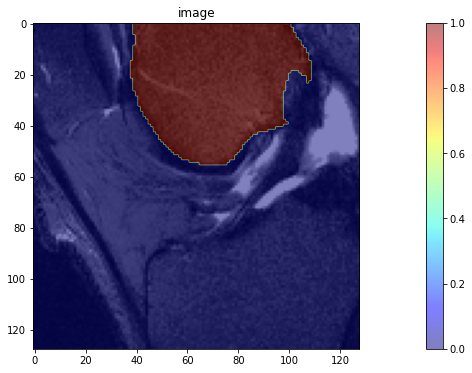

In [12]:
import matplotlib.pyplot as plt
# pick one image from data to visualize and check 
img = train_ds[0]

print(f"image shape: {img['image'].shape}")
plt.figure("image", (24, 6))
plt.title(f"image")
plt.imshow(img["image"][0, :, :,15], cmap="gray")
plt.imshow(img["label"][0, :, :, 15], cmap="jet", alpha=0.5)
plt.colorbar()
plt.show()

In [13]:
# Start tensorboard
from torch.utils.tensorboard import SummaryWriter
import tensorboard
writer = SummaryWriter()

Run either load or reload of the tensorboard (depending if you've got one already running)

In [14]:
%load_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 30904), started 2 days, 13:02:04 ago. (Use '!kill 30904' to kill it.)

In [15]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=3,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)
loss_function = DiceLoss(to_onehot_y=False, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(
    model.parameters(), 1e-4, weight_decay=1e-5, amsgrad=True
)

In [ ]:
# Alternative network architecture: VNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3
).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), 1e-4, weight_decay=1e-5, amsgrad=True
)

## Transfer Learning
Load the pre trained weights as the 'root'
Set the 'filename' to save the trained results 

In [66]:
# Save/load model at this location. Edit the directory on your local setup. 
model_path = "C:\\Users\\Johnny\\Documents\\Maria's Stuff\\ABI\\Knee Segmentation\\trained_weights\\13Dec_v3_intactKnees_12816_b4.pth"

print("The model will be saved in:", model_path)

The model will be saved in: C:\Users\Johnny\Documents\Maria's Stuff\ABI\Knee Segmentation\trained_weights\13Dec_v3_intactKnees_12816_b4.pth


### Continued Training ##


If continuing training from a base model or checkpoint, run the following block. 

Adjust the path and filename to the checkpoint (.pt) that you need. 

In [67]:
# Load from a checkpoint to continue training
PATH = "/Checkpoints/model_checkpoint_13Dec_v3.pt" #TODO:  ADJUST THIS PATH
def load_checkpoint(model, optimizer, loss, filename=PATH):
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))

        checkpoint = torch.load(PATH)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']

        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, epoch, loss

## Train UNet ##

In [18]:
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=True)

hausdorff_metric = HausdorffDistanceMetric(include_background=False, distance_metric="euclidean", get_not_nans=True)

Check availability of CUDA-enabled GPU for PyTorch training

In [18]:
# Check if ya got a CUDA device for accelerated training
x = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA device found. Training will be hella slow :("
print(x)

NVIDIA GeForce GTX 1060 6GB


In [19]:
# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

In [68]:
%reload_ext tensorboard

In [69]:
# Date and version naming convention: DDMon_v#
RUN_NAME = "13Dec_v3" 

In [38]:
max_epochs = 500
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
metric_values_tc = [] # Femur
metric_values_wt = [] # Tibia
metric_values_et = [] # ACL
hausdorff_values = []

PATH = os.path.join(".\Checkpoints\\", RUN_NAME+'.pt')

# Load model from checkpoint
start_epoch = 0
#model, optimizer, start_epoch, epoch_loss = load_checkpoint(model, optimizer, loss_function, PATH)
epochs_to_go = max_epochs-start_epoch
total_start = time.time()
for epoch in range(epochs_to_go):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + start_epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)

    # TensorBoard-ing stuff to see during training
    writer.add_scalar("Epoch Loss/Training", epoch_loss, epoch)

    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # Save checkpoint
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
            }, PATH)


    # Evaulate the model performance with validation data set
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            dice_metric = DiceMetric(include_background=False, reduction="mean")
            post_trans = Compose(
                [Activations(sigmoid=True), AsDiscrete(threshold_values=True),
                 KeepLargestConnectedComponent(applied_labels=[0,1,2], independent=False)]
            )

            metric_sum = metric_sum_tc = metric_sum_wt = metric_sum_et = 0.0
            metric_count = (
                metric_count_tc
            ) = metric_count_wt = metric_count_et = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                # val_outputs = model(val_inputs)
                roi_size = (256, 256, 16)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)

                val_outputs = post_trans(val_outputs)

                # Compute Hausdorff
                HAUSDORFF_SCORE = hausdorff_metric(y_pred=val_outputs, y=val_labels)
                print("HAUSDORFF: ", HAUSDORFF_SCORE[0].item())
                hd = HAUSDORFF_SCORE[0].item()
                hausdorff_values.append(hd)

                # compute overall mean dice
                value, not_nans = dice_metric(y_pred=val_outputs, y=val_labels)
                not_nans = not_nans.item()
                metric_count += not_nans
                metric_sum += value.item() * not_nans
                # compute mean dice for TC
                value_tc, not_nans = dice_metric(
                    y_pred=val_outputs[:, 0:1], y=val_labels[:, 0:1]
                )
                not_nans = not_nans.item()
                metric_count_tc += not_nans
                metric_sum_tc += value_tc.item() * not_nans
                # compute mean dice for WT
                value_wt, not_nans = dice_metric(
                    y_pred=val_outputs[:, 1:2], y=val_labels[:, 1:2]
                )
                not_nans = not_nans.item()
                metric_count_wt += not_nans
                metric_sum_wt += value_wt.item() * not_nans
                # compute mean dice for ET
                value_et, not_nans = dice_metric(
                    y_pred=val_outputs[:, 2:3], y=val_labels[:, 2:3]
                )
                not_nans = not_nans.item()
                metric_count_et += not_nans
                metric_sum_et += value_et.item() * not_nans

            metric = metric_sum / metric_count
            metric_values.append(metric)
            metric_tc = metric_sum_tc / metric_count_tc
            metric_values_tc.append(metric_tc)
            metric_wt = metric_sum_wt / metric_count_wt
            metric_values_wt.append(metric_wt)
            metric_et = metric_sum_et / metric_count_et
            metric_values_et.append(metric_et)

            val_loss = loss_function(val_outputs, val_labels)

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(
                    model.state_dict(),
                    model_path,
                )
                print("saved new best metric model")

            writer.add_scalar("Validation/Dice Score", metric, epoch)
            writer.add_scalar("Metric/ACL", metric_et, epoch)
            writer.add_scalar("Metric/Femur", metric_tc, epoch)
            writer.add_scalar("Metric/Tibia", metric_wt, epoch)
            writer.add_scalar("Validation/Hausdorff Distance", hd, epoch)

            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" femur: {metric_tc:.4f} tibia: {metric_wt:.4f} acl: {metric_et:.4f}"
                f"\nHausdorff: {hd:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
writer.flush()
total_time = time.time() - total_start
writer.close()

----------
epoch 1/800
1/42, train_loss: 0.7833, step time: 0.3391
2/42, train_loss: 0.6598, step time: 0.1705
3/42, train_loss: 0.6901, step time: 0.1656
4/42, train_loss: 0.6363, step time: 0.1586
5/42, train_loss: 0.6889, step time: 0.1576
6/42, train_loss: 0.6720, step time: 0.1586
7/42, train_loss: 0.7019, step time: 0.1586
8/42, train_loss: 0.7130, step time: 0.1566
9/42, train_loss: 0.6448, step time: 0.1566
10/42, train_loss: 0.7914, step time: 0.1566
11/42, train_loss: 0.6689, step time: 0.1556
12/42, train_loss: 0.7282, step time: 0.1586
13/42, train_loss: 0.8114, step time: 0.1566
14/42, train_loss: 0.7470, step time: 0.1576
15/42, train_loss: 0.7122, step time: 0.1576
16/42, train_loss: 0.6964, step time: 0.1566
17/42, train_loss: 0.7178, step time: 0.1566
18/42, train_loss: 0.7369, step time: 0.1566
19/42, train_loss: 0.7885, step time: 0.1566
20/42, train_loss: 0.6925, step time: 0.1576
21/42, train_loss: 0.6715, step time: 0.1576
22/42, train_loss: 0.7097, step time: 0.1

In [39]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

train completed, best_metric: 0.7443 at epoch: 762, total time: 33819.40095567703.


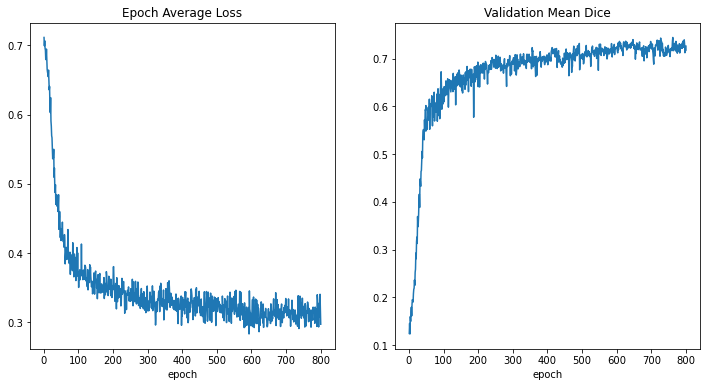

In [44]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 + start_epoch for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Validation Mean Dice")
x = [val_interval * (i + start_epoch + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
# plt.ylim([0,1.0])
plt.show()

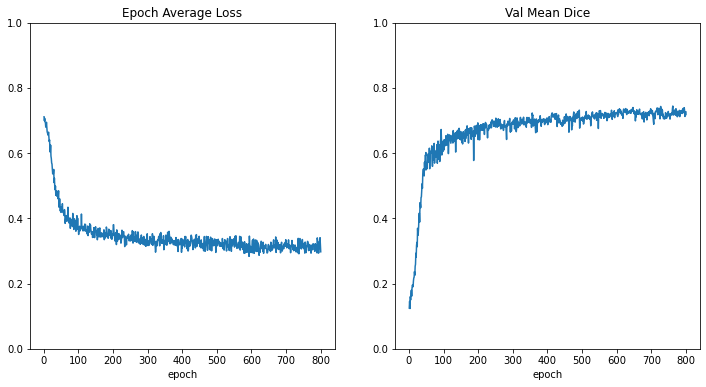

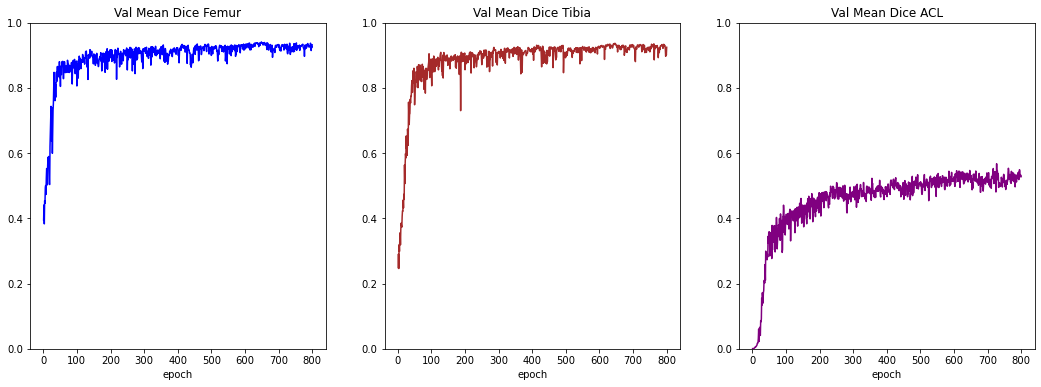

In [50]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 + start_epoch for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.ylim([0, 1.0])

plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1 + start_epoch) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.ylim([0, 1.0])
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice Femur")
x = [val_interval * (i + 1 + start_epoch) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.ylim([0, 1.0])
plt.plot(x, y, color="blue")

plt.subplot(1, 3, 2)
plt.title("Val Mean Dice Tibia")
x = [val_interval * (i + 1 + start_epoch) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.ylim([0, 1.0])

plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ACL")
x = [val_interval * (i + 1 + start_epoch) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.ylim([0, 1.0]) # This scales the Dice score axis to 1.0 so that it is the same as the previous two. 
plt.show()

Load some MRIs and the trained model. View the images, label, and model outputs together. 

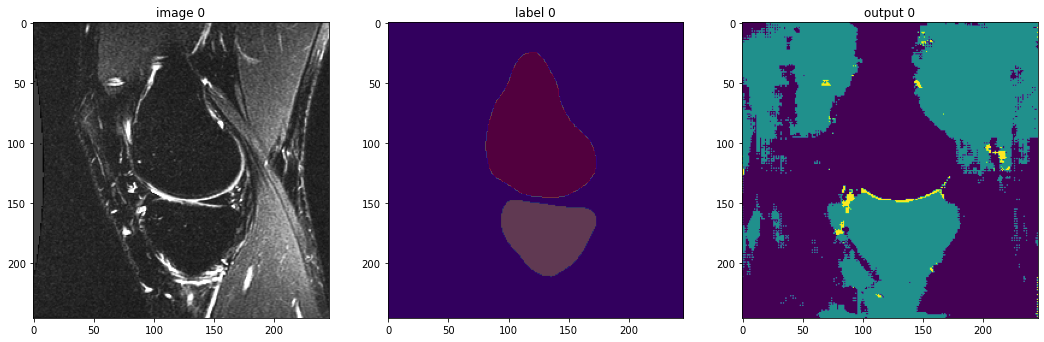

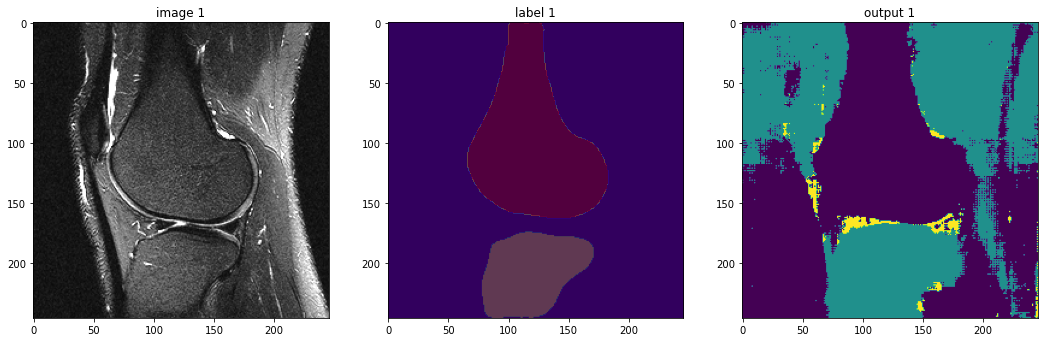

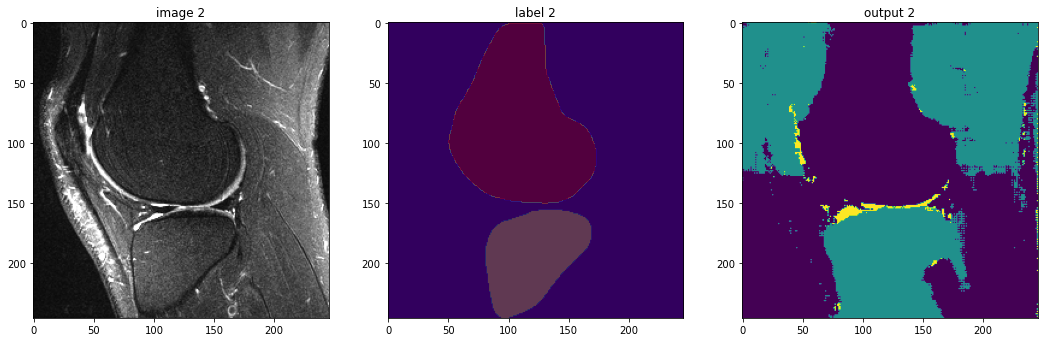

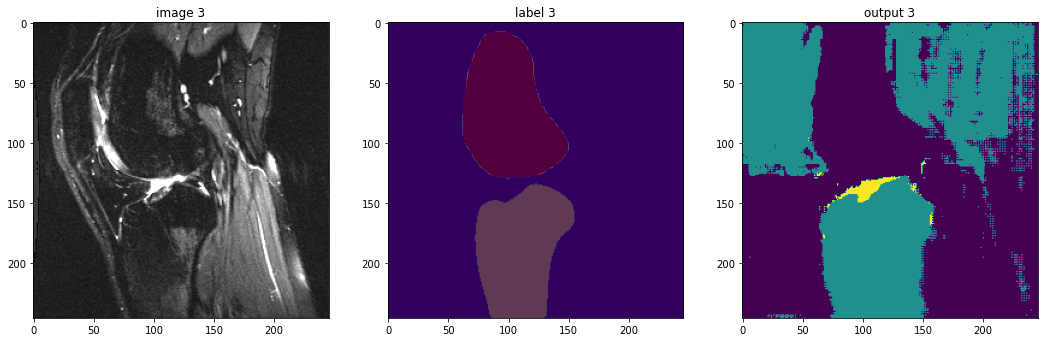

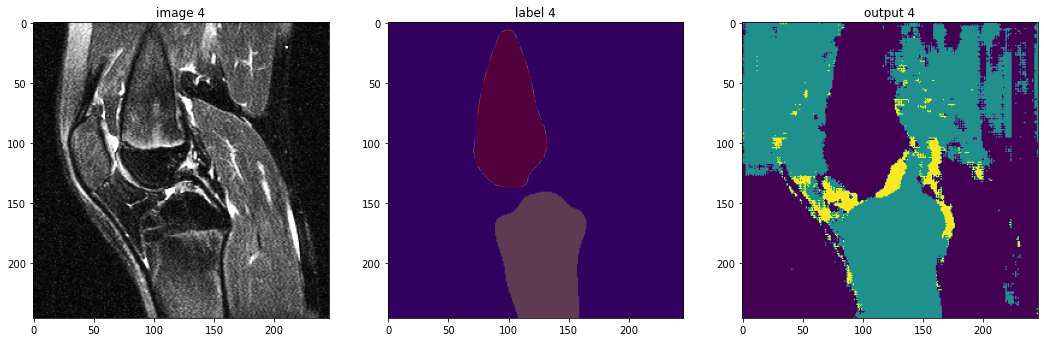

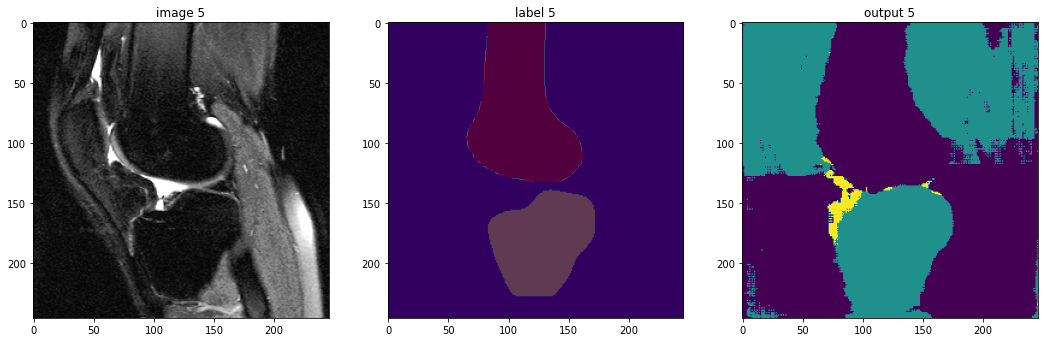

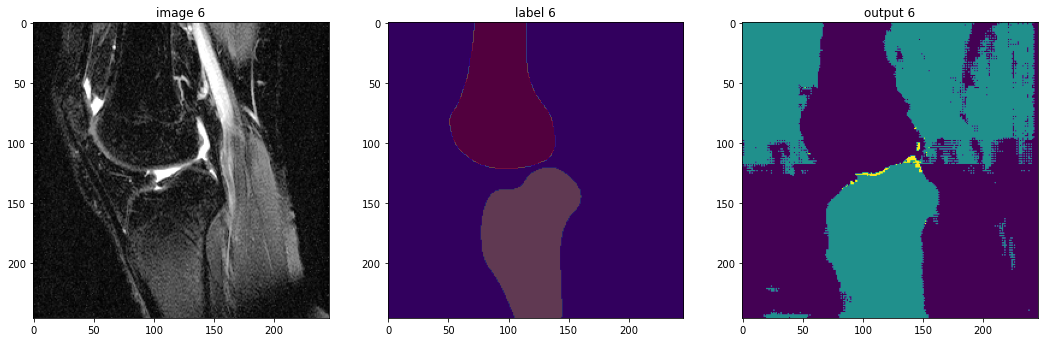

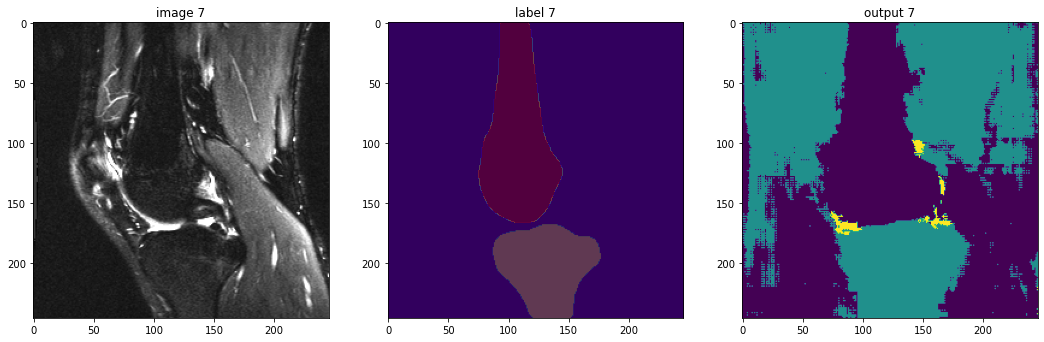

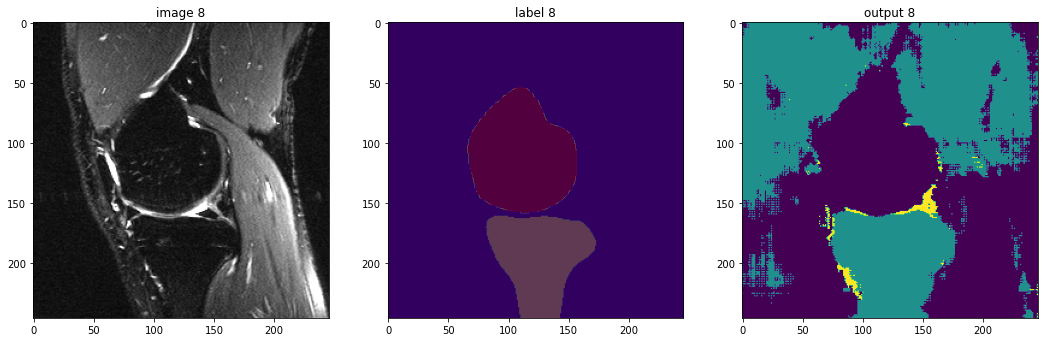

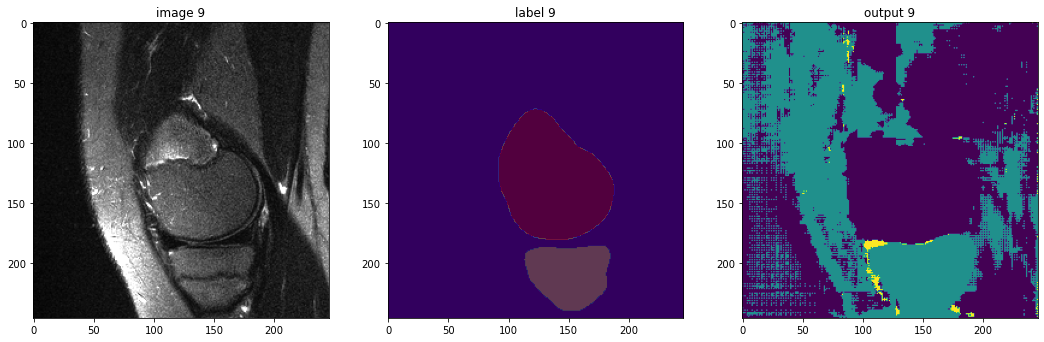

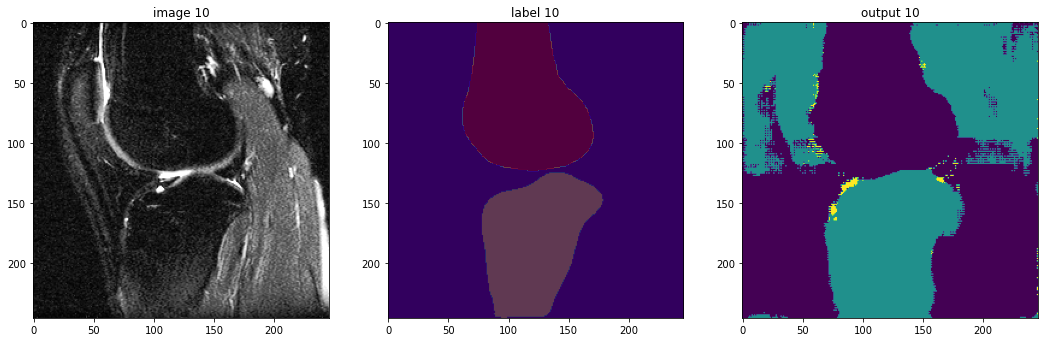

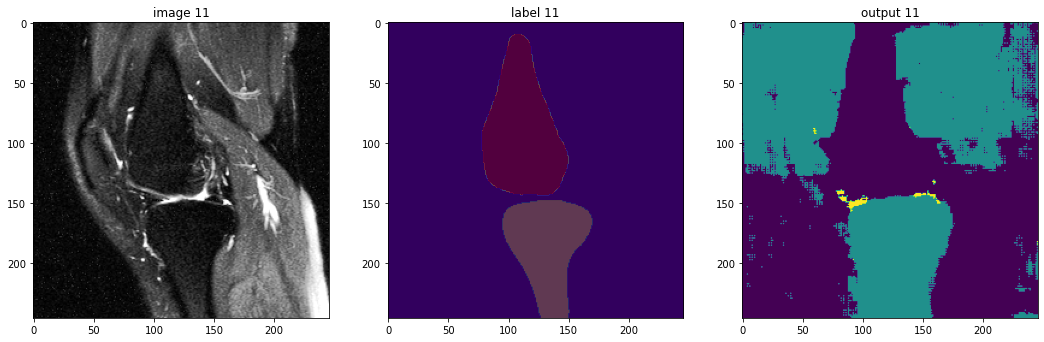

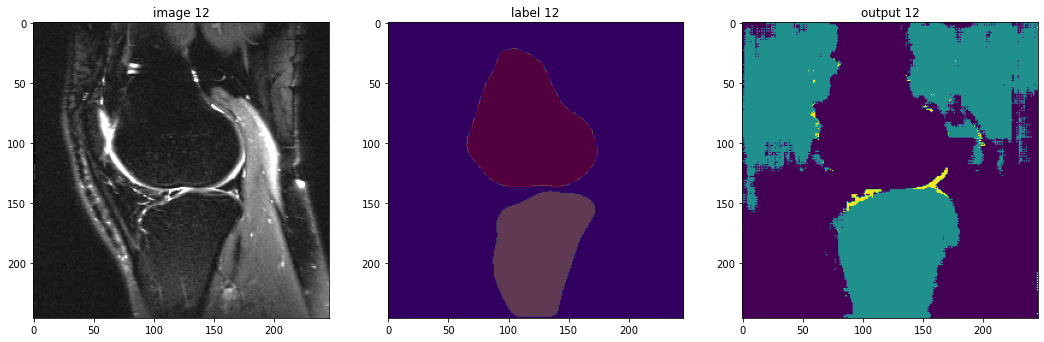

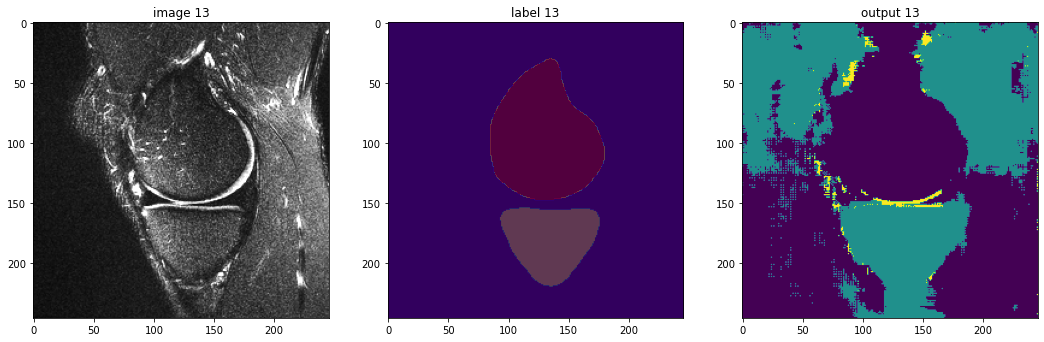

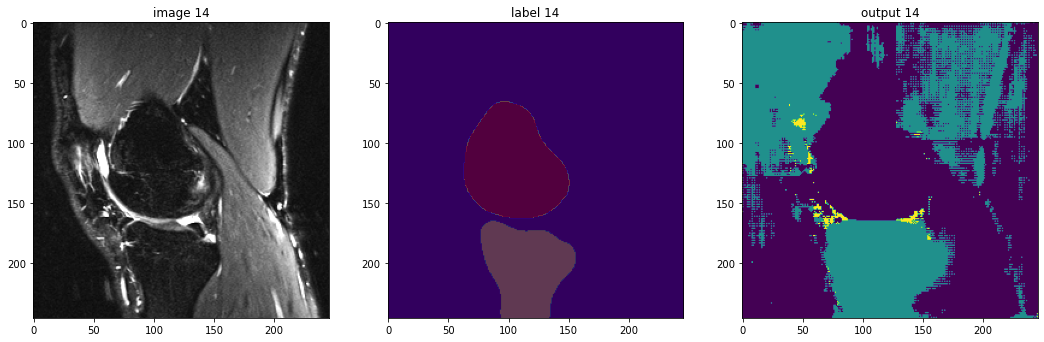

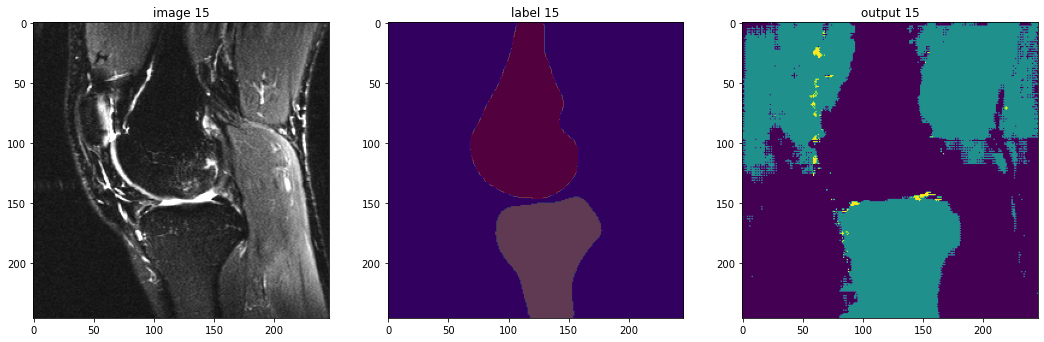

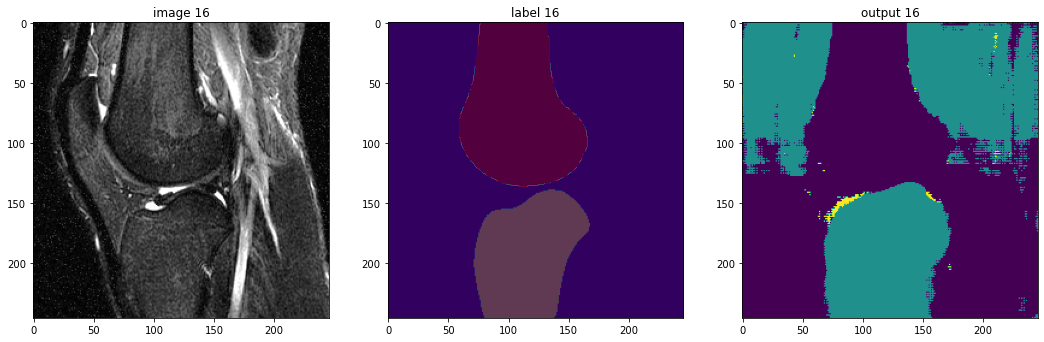

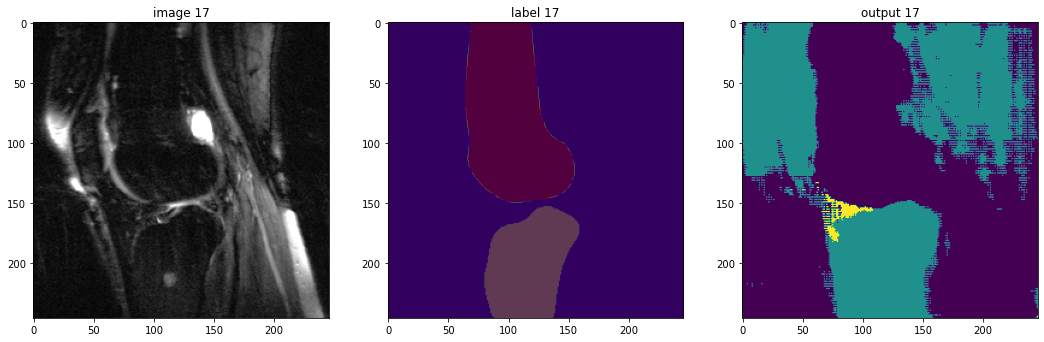

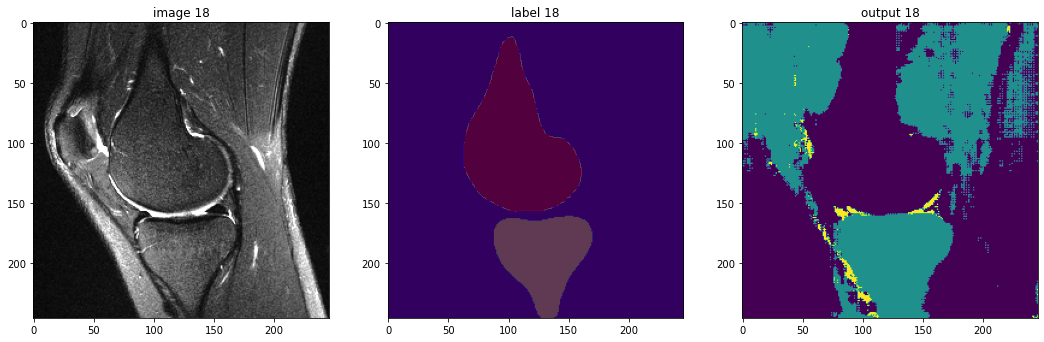

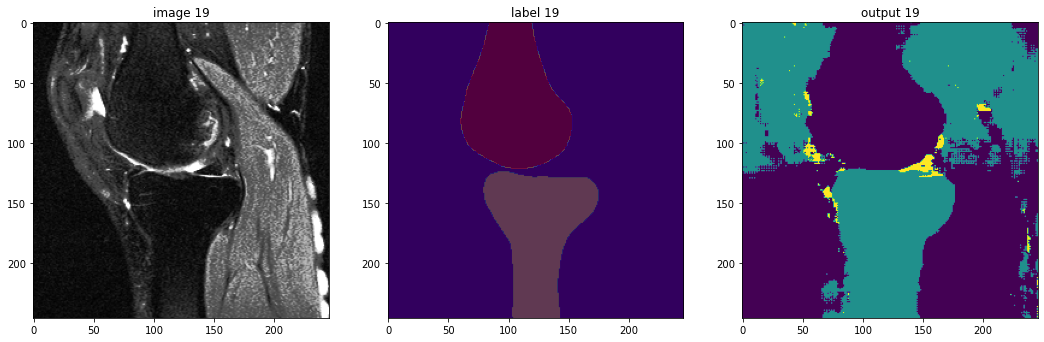

In [51]:
model.load_state_dict(torch.load(model_path))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (128, 128, 16)
        sw_batch_size = 12
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 12]
        SLICE = 8
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, SLICE], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, SLICE], cmap="jet")
        plt.imshow(val_data["label"][0, 1, :, :, SLICE], alpha=0.5)
        plt.imshow(val_data["label"][0, 2, :, :, SLICE], alpha=0.5)
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0,0:, :, SLICE])
        plt.show()


Test out the trained model on some real data

In [1]:
# Load the trained model (default to GPU. state to CPU if needed)
model.load_state_dict(
    torch.load("C:\\Users\\Johnny\\Documents\\Maria's Stuff\\ABI\\Knee Segmentation\\trained_weights\\13Dec_v2_intactKnees_12816_b4.pth")
)

def get_name(number):
    if (number == 0):
        return 'Femur'
    elif (number == 1):
        return 'Tibia'
    elif (number == 2):
        return 'ACL'
    else:
        return 'Unknown'


#~ Evaluate the model 
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    subject = test_ds[4]     # Select one scan from the final test dataset     
    SLICE = 16              # Adjust Slice number here
    roi_size = (256,256,16)
    sw_batch_size = 4

    val_input = subject["image"].unsqueeze(0).to(device)
    print(subject["image"].shape)
    # val_output = model(val_input)
    val_output = sliding_window_inference(
            val_input, roi_size, sw_batch_size, model
        )
    
    after_transform = Compose([
                     Activations(sigmoid=True), AsDiscrete(threshold_values=0.5),
                 KeepLargestConnectedComponent(applied_labels=[0,1,2], independent=True)
    ])
    val_output = after_transform(val_output)

    # Plot the results
    plt.figure("image", (24, 6))
    plt.subplot(1, 4,1)
    plt.title(f"image channel")
    plt.imshow(subject["image"][0, :, :, SLICE].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        anatomy = get_name(i)
        plt.title(f"{anatomy}")
        plt.imshow(subject["label"][i, :, :, SLICE].detach().cpu())

    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (25, 8))
    for i in range(3):
        anatomy = get_name(i)
        plt.subplot(1, 3, i + 1)
        plt.title(f"{anatomy}")
        plt.imshow(subject["image"][0, :, :, SLICE].detach().cpu(), cmap="bone")
        plt.imshow(val_output[0, i, :, :, SLICE].detach().cpu(), alpha=0.7, cmap="magma")
        plt.colorbar()
    plt.show()

    plt.figure("overlay", (25, 8))
    for i in range(3):
        anatomy = get_name(i)
        plt.subplot(1, 3, i + 1)
        plt.title(f"{anatomy}")
        plt.imshow(subject["image"][0, :, :, SLICE].detach().cpu(), cmap="bone")
        plt.imshow(subject["label"][i, :, :, SLICE].detach().cpu(), alpha=0.7, cmap="gist_gray")
        plt.imshow(val_output[0, i, :, :, SLICE].detach().cpu(), alpha=0.5, cmap="magma")
        # plt.colorbar()

        
    plt.show()

    _dice_score = dice_metric(y_pred= subject["label"].detach().cpu(), y=val_output.squeeze())
    print(_dice_score)

NameError: name 'model' is not defined